In [1]:
import sys
from utils import data_utils
import helper
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math

In [2]:
config = helper.Config("./simulations")

[INFO]
num_nodes = 1
gpu_per_node = 1
num_workers = 8

[DATA]
dataset = CIFAR10
n_views = 10
augmentations = GaussianBlur
blur_kernel_size = 3

[SSL]
backbone = resnet18
embedded_dim = 12
optimizer = SGD
use_projection_header = yes
proj_dim = 10
lr = 0.0005
momentum = 0.99
weight_decay = 0.1
lars_eta = 0.1
loss_function = EllipsoidPackingLoss
lw0 = 1.0
lw1 = 1.0
lw2 = 1.0
rs = 3.0
warmup_epochs = 1
n_epochs = 4
batch_size = 128
save_every_n_epochs = 1

[LC]
output_dim = 10
optimizer = SGD
use_batch_norm = yes
lr = 0.01
momentum = 0.99
loss_function = CrossEntropyLoss
n_epochs = 4
batch_size = 128
save_every_n_epochs = 1
training_mode = scan_pretrained_epochs

[IO]
restart = yes



Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


390


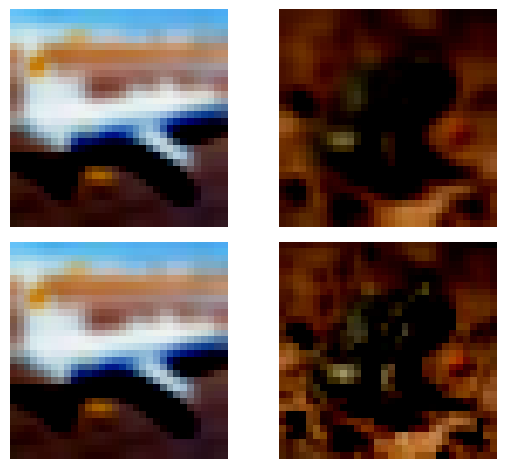

In [3]:
# for multi-gpu trainning, effective batch size = batch_size*num_gpus
ssl_batch_size = config.SSL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
lc_batch_size = config.LC["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])

ssl_train_loader,lc_train_loader,test_loader= data_utils.get_dataloader(config.DATA,ssl_batch_size,lc_batch_size,config.INFO["num_workers"])
imgs,labels = next(iter(ssl_train_loader))
img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)
print(len(ssl_train_loader))

In [4]:
if config.SSL["lr_scale"] == "linear":
    ssl_lr = config.SSL["lr"]*config.SSL["batch_size"]/256.0 # lr ~ 0.1
elif config.SSL["lr_scale"] == "sqrt":
    ssl_lr = config.SSL["lr"]*math.sqrt(config.SSL["batch_size"]) # lr ~ 0.05
ssl_model = lightning_models.CLAP(embedded_dim = config.SSL["embedded_dim"],
                                  backbone_name = config.SSL["backbone"],
                                  use_projection_header=config.SSL["use_projection_header"],
                                  proj_dim = config.SSL["proj_dim"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = ssl_lr,
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"])

# remove the max pooling layer and change the conv1 layer 
# for CIFAR10 dataset since the image is small(32*32)
if config.DATA["dataset"] == "CIFAR10":
    ssl_model.backbone.remove_maxpool()
    ssl_model.backbone.replace_conv1()

In [5]:
ssl_dir = os.path.join(config.loc,"ssl")
if not os.path.isdir(ssl_dir):
    os.makedirs(ssl_dir)
ssl_model = lightning_models.train_clap(model=ssl_model, train_loader = ssl_train_loader,
            max_epochs=config.SSL["n_epochs"],every_n_epochs = config.SSL["save_every_n_epochs"],
                                        checkpoint_path=ssl_dir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model at ./simulations/ssl/last.ckpt, loading...


In [6]:
lc_dir = os.path.join(config.loc,"lc")
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)
ssl_model.backbone.remove_projection_header()
if config.LC["lr_scale"] == "linear":
    lc_lr = config.LC["lr"]*config.LC["batch_size"]/256.0 # lr ~ 0.1
elif config.LC["lr_scale"] == "sqrt":
    lc_lr = config.LC["lr"]*math.sqrt(config.LC["batch_size"]) # lr ~ 0.05
lc_model = lightning_models.LinearClassification(
                 in_dim = config.SSL["embedded_dim"],
                 out_dim = config.LC["output_dim"],
                 use_batch_norm = config.LC["use_batch_norm"],
                 optim_name = config.LC["optimizer"],
                 lr = lc_lr, 
                 momentum = config.LC["momentum"],
                 weight_decay = config.LC["weight_decay"],
                 n_epochs = config.LC["n_epochs"])
lc_model.set_backbone(ssl_model.backbone)
lc_model = lightning_models.train_lc(ssl_model = ssl_model, 
            ssl_ckpt_path = ssl_dir,
            linear_model = lc_model,
            train_loader = lc_train_loader,
            test_loader = test_loader,
            max_epochs = config.LC["n_epochs"],
            every_n_epochs = config.LC["save_every_n_epochs"],
            checkpoint_path = lc_dir,
            mode = config.LC["training_mode"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | linear_net | BnLinearNet | 154    | train
1 | backbone   | BackboneNet | 11.2 M | train
---------------------------------------------------
154       Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.731    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


loading ssl model from CLAP-epoch=03.ckpt.ckpt


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


avgloss = 2.398946523666382
avgloss = 2.3988373279571533
avgloss = 2.3989837169647217


`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


avgloss = 2.3989346027374268


/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     batch_test_acc1        0.09435096383094788
     batch_test_acc5        0.49619391560554504
     batch_test_loss        2.3963844776153564
        test_acc1           0.09435096383094788
        test_acc5           0.49619391560554504
        test_loss           2.3963849544525146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loading ssl model from CLAP-epoch=02.ckpt.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | linear_net | BnLinearNet | 154    | train
1 | backbone   | BackboneNet | 11.2 M | train
---------------------------------------------------
154       Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.731    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

avgloss = 2.3870396614074707
avgloss = 2.3791353702545166
avgloss = 2.373466968536377


`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


avgloss = 2.3692209720611572


/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     batch_test_acc1        0.14623397588729858
     batch_test_acc5        0.5172275900840759
     batch_test_loss        2.3354451656341553
        test_acc1           0.12029246985912323
        test_acc5           0.5067107677459717
        test_loss            2.365915536880493
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loading ssl model from CLAP-epoch=01.ckpt.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | linear_net | BnLinearNet | 154    | train
1 | backbone   | BackboneNet | 11.2 M | train
---------------------------------------------------
154       Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.731    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

avgloss = 2.36757755279541
avgloss = 2.3661651611328125
avgloss = 2.3650426864624023


`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


avgloss = 2.364112138748169


/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     batch_test_acc1        0.15164263546466827
     batch_test_acc5        0.5334535241127014
     batch_test_loss        2.3451900482177734
        test_acc1           0.13074253499507904
        test_acc5                0.515625
        test_loss           2.3590073585510254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
loading ssl model from CLAP-epoch=00.ckpt.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | linear_net | BnLinearNet | 154    | train
1 | backbone   | BackboneNet | 11.2 M | train
---------------------------------------------------
154       Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.731    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

avgloss = 2.369856595993042
avgloss = 2.3747878074645996
avgloss = 2.379084587097168


`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


avgloss = 2.382829427719116


/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     batch_test_acc1        0.13060897588729858
     batch_test_acc5        0.4880809187889099
     batch_test_loss        2.4248580932617188
        test_acc1           0.13070914149284363
        test_acc5           0.5087389945983887
        test_loss            2.37546968460083
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
lc_model.load_from_customized_checkpoint(os.path.join("./simulations/lc","last.ckpt"))